# Partie II: Prévisions et évaluation climatique

In [1]:
# Imports
%matplotlib inline
import time
from IPython.display import Image

import matplotlib.pyplot as plt
#import sys
#!{sys.executable} -m pip install numba

# Make sure you have pytorch installed
import numpy as np
import torch
import torch.utils.data as Data
from torch import nn, optim

# Make sure you place L96_model in the same folder as the notebook! 
from L96_model import L96, RK2, RK4, EulerFwd, L96_eq1_xdot, integrate_L96_2t

# Latex
plt.rcParams["text.usetex"] = True

# Seaborn
import seaborn as sns

In [2]:
# Ensuring reproducibility
np.random.seed(14)
torch.manual_seed(14);

In [3]:
# Add your own modified NN here and make sure you load the weights!!
# Simple regression model
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 1)  # A single input and a single output

    def forward(self, x):
        # This method is automatically executed when
        # we call a object of this class
        x = self.linear1(x)
        return x

# Simple Neural Network
class FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(1, 16)  # 1 inputs
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, 1)  # 1 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

class NonLocal_FCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(8, 32)  # 8 inputs
        self.linear2 = nn.Linear(32, 64)
        self.linear3 = nn.Linear(64, 8)  # 8 outputs

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [4]:
linear_weights = torch.load("linear.pth")
local_FCNN_weights = torch.load("local_NN.pth")
nonlocal_FCNN_weights = torch.load("non_local_NN.pth")

# Initialize network instances and assign pre-trained weights.
linear_network = LinearRegression()
linear_network.load_state_dict(linear_weights)

local_fcnn_network = FCNN()
local_fcnn_network.load_state_dict(local_FCNN_weights)

nonlocal_fcnn_network = NonLocal_FCNN()
nonlocal_fcnn_network.load_state_dict(nonlocal_FCNN_weights)

<All keys matched successfully>

In [5]:
# L96 without Y. Les effets des Y sur les X sont ignorés
class GCM_without_parameterization: 
    """GCM without parameterization

    Args:
        F: Forcing term
        time_stepping: Time stepping method
    """

    def __init__(self, F, time_stepping=RK4):
        self.F = F
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        return L96_eq1_xdot(X, self.F)

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [ ]:
# L96 with P_NN(X) parameterization
class GCM_network:
    """GCM with neural network parameterization

    Args:
        F: Forcing term
        network: Neural network
        time_stepping: Time stepping method
    """

    def __init__(self, F, network, time_stepping=RK4):
        self.F = F
        self.network = network
        self.time_stepping = time_stepping

    def rhs(self, X, _):
        """Compute right hand side of the the GCM equations"""
        if self.network.linear1.in_features == 1: # S'il y a un seul imput (linéaire, 1D)
            X_torch = torch.from_numpy(X)
            X_torch = torch.unsqueeze(X_torch, 1)
        else:
            X_torch = torch.from_numpy(np.expand_dims(X, 0))

        # Adding NN parameterization
        return L96_eq1_xdot(X, self.F) + np.squeeze(self.network(X_torch).data.numpy()) # Faire prédiction pour C_k et ajouter au résultat de la dérivée

    def __call__(self, X0, dt, nt, param=[0]):
        """Run GCM

        Args:
            X0: Initial conditions of X
            dt: Time increment
            nt: Number of forward steps to take
            param: Parameters of closure

        Returns:
            Model output for all variables of X at each timestep
            along with the corresponding time units
        """
        time, hist, X = (
            dt * np.arange(nt + 1),
            np.zeros((nt + 1, len(X0))) * np.nan,
            X0.copy(),
        )
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs, dt, X, param)
            hist[n + 1], time[n + 1] = X, dt * (n + 1)
        return hist, time

In [ ]:
# Forecasting parameters
T_test = 10 # Temps total (s). Nombre de pas de temps = T_test/dt
forcing = 18
dt = 0.01 # s

k = 8
j = 32

W = L96(k, j, F=forcing)

# Full L96 model (two time scale model)
X_full, _, _ = W.run(dt, T_test)
X_full = X_full.astype(np.float32) # (1001,8)

init_conditions = X_full[0, :]

In [8]:
gcm_no_param = GCM_without_parameterization(forcing)
X_no_param, t = gcm_no_param(init_conditions, dt, int(T_test / dt))

In [ ]:
# Rouler le modèle pour les 3 réseaux
# Evaluate with linear network
gcm_linear_net = GCM_network(forcing, linear_network)
Xnn_linear, t = gcm_linear_net(init_conditions, dt, int(T_test / dt), linear_network) 

# Evaluate with local FCNN
gcm_local_net = GCM_network(forcing, local_fcnn_network)
Xnn_local, t = gcm_local_net(init_conditions, dt, int(T_test / dt), local_fcnn_network)

# Evaluate with nonlocal FCNN
gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
Xnn_nonlocal, t = gcm_nonlocal_net(
    init_conditions, dt, int(T_test / dt), nonlocal_fcnn_network
)

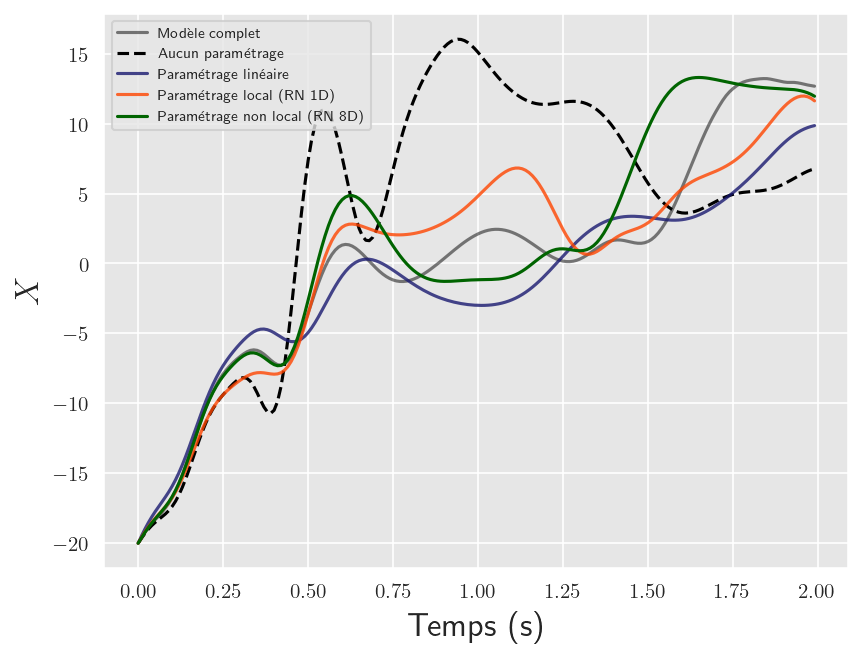

In [ ]:
# Voir comment évolue un même état initial au fil du temps dans les différents modèles
time_i = 200 # Nombre de pas de temps à afficher
plt.figure(dpi=150)
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

plt.plot(t[:time_i], X_full[:time_i, 4], label="Modèle complet", color='k', alpha=0.5)
plt.plot(t[:time_i], X_no_param[:time_i, 4], "--", label="Aucun paramétrage", color='k')

plt.plot(t[:time_i], Xnn_linear[:time_i, 4], label="Paramétrage linéaire", color='midnightblue', alpha=0.8)
plt.plot(t[:time_i], Xnn_local[:time_i, 4], label="Paramétrage local (RN 1D)", color='orangered', alpha=0.8)
plt.plot(t[:time_i], Xnn_nonlocal[:time_i, 4], label="Paramétrage non local (RN 8D)", color='darkgreen')

plt.legend(loc="upper left", fontsize=7);
plt.ylabel(r"$X$",fontsize=16)
plt.xlabel("Temps (s)",fontsize=16)

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/Eval_multiples_1.png',dpi=500)

In [ ]:
# Checking over many different initial conditions
err_linear, err_local, err_nonlocal = [], [], []
T_test = 1 # s

for i in range(90):
    init_conditions_i = X_full[i * 10, :] # Conditions initiales pigées des données générées avec W.run()

    # Evaluate with linear network
    gcm_linear_net = GCM_network(forcing, linear_network)
    Xnn_linear, t = gcm_linear_net( # Pour une même c.i., on roule le modèle sur tous les pas de temps
        init_conditions_i, dt, int(T_test / dt), linear_network
    )

    # Evaluate with local FCNN
    gcm_local_net = GCM_network(forcing, local_fcnn_network)
    Xnn_local, t = gcm_local_net(
        init_conditions_i, dt, int(T_test / dt), local_fcnn_network
    )

    # Evaluate with nonlocal FCNN
    gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
    Xnn_nonlocal, t = gcm_nonlocal_net(
        init_conditions_i, dt, int(T_test / dt), nonlocal_fcnn_network
    )

    # GCM parameterized by the global 3-layer network
    # gcm_net_3layers = GCM_network(forcing, nn_3l)
    # Xnn_3layer_i, t = gcm_net_3layers(init_conditions_i, dt, int(T_test / dt), nn_3l)

    # GCM parameterized by the linear network
    # gcm_net_1layers = GCM_network(forcing, linear_network)
    # Xnn_1layer_i, t = gcm_net_1layers(init_conditions_i, dt, int(T_test / dt), linear_network)

    err_linear.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_linear)) 
        # On va chercher les valeurs vraies dans la matrice
        # Valeurs cherchées entre la ligne des conditions initiales et la ligne finale
        # Valeur absolue de l'erreur
    )

    err_local.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_local))
    )

    err_nonlocal.append(
        np.sum(np.abs(X_full[i * 10 : i * 10 + T_test * 100 + 1] - Xnn_nonlocal))
    )

print(f"Sum of errors for linear: {sum(err_linear):.2f}")
print(f"Sum of errors for local neural network: {sum(err_local):.2f}")
print(f"Sum of errors for non-local neural network: {sum(err_nonlocal):.2f}")

"""Sum of errors for linear: 46336.37
Sum of errors for local neural network: 33222.21
Sum of errors for non-local neural network: 31142.73"""

Sum of errors for linear: 46336.37
Sum of errors for local neural network: 33222.21
Sum of errors for non-local neural network: 31142.73


'Sum of errors for linear: 46336.37\nSum of errors for local neural network: 33222.21\nSum of errors for non-local neural network: 31142.73'

## Évaluation de la performance du nouveau modèle pour une prévision

#### Lancer la simulation

In [27]:
# Constantes
T_court = 9 # s
dt = 0.01 # s
forcing = 18
k = 8
j = 32

# MCG (vérité)
W = L96(k, j, F=forcing)
X_court, _, _ = W.run(dt, T_court)
X_court = X_court.astype(np.float32)

cond_initiales = X_court[0, :]

# Modèle linéaire
gcm_linear_net = GCM_network(forcing, linear_network)
Xevolution_linear, t = gcm_linear_net(cond_initiales, dt, int(T_court / dt), linear_network)

# RN 1D
gcm_local_net = GCM_network(forcing, local_fcnn_network)
Xevolution_local, t = gcm_local_net(cond_initiales, dt, int(T_court / dt), local_fcnn_network)

# RN 8D
gcm_nonlocal_net = GCM_network(forcing, nonlocal_fcnn_network)
Xevolution_nonlocal, t = gcm_nonlocal_net(cond_initiales, dt, int(T_court / dt), nonlocal_fcnn_network)

#### Hovmöller de l'erreur

/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/3837514622.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(x_tick_labels, fontsize=14)
/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/3837514622.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_yticklabels(y_tick_labels,fontsize=14)
/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/3837514622.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(x_tick_labels, fontsize=14)
/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/3837514622.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
 

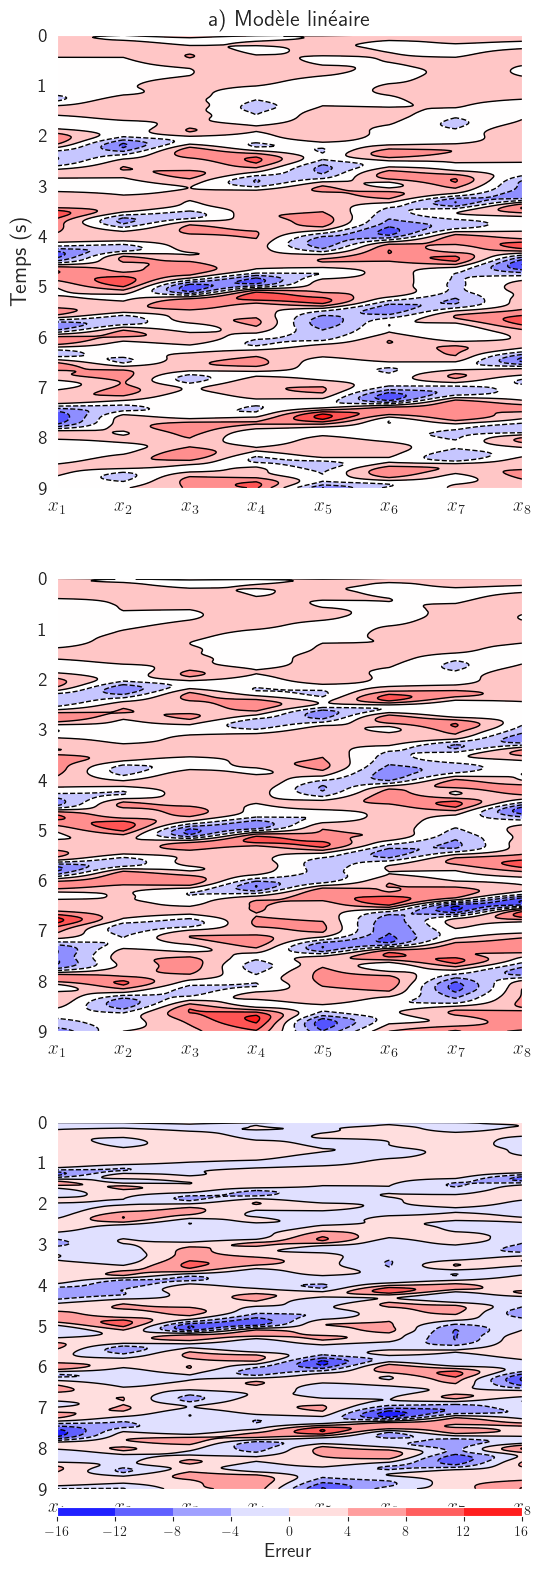

In [ ]:
# From: https://unidata.github.io/python-gallery/examples/Hovmoller_Diagram.html

# Hovmoller data
hov_linear = Xevolution_linear - X_court
hov_local = Xevolution_local - X_court
hov_nlocal = Xevolution_nonlocal - X_court

# Start figure
fig, ax = plt.subplots(3,1, figsize=(6, 20))

#ax = fig.add_subplot(gs[1, 0])
# Invert y axis
ax[0].invert_yaxis()  # Reverse the time order to do oldest first
ax[1].invert_yaxis()
ax[2].invert_yaxis()

# Plot linear
cf = ax[0].contourf(hov_linear, cmap='bwr', extend='neither') #cmap=plt.cm.bwr,
cs = ax[0].contour(hov_linear, colors='k', linewidths=1) # Black delimiter lines
# Plot RN 1D
cf = ax[1].contourf(hov_local, cmap='bwr', extend='neither') #cmap=plt.cm.bwr,
cs = ax[1].contour(hov_local, colors='k', linewidths=1) # Black delimiter lines
# Plot RN 8D
cf = ax[2].contourf(hov_nlocal, cmap='bwr', extend='neither') #cmap=plt.cm.bwr,
cs = ax[2].contour(hov_nlocal, colors='k', linewidths=1) # Black delimiter lines

# Colorbar
cbar = plt.colorbar(cf, orientation='horizontal', pad=0.04, aspect=50, extendrect=True)
cbar.set_label('Erreur',fontsize=14)

# Make some ticks and tick labels 
x_tick_labels = [r"$x_1$", r"$x_2$", r"$x_3$", r"$x_4$", r"$x_5$", r"$x_6$", r"$x_7$", r"$x_8$"]
y_tick_labels = np.arange(0,10,1)
for i in range(3):
    ax[i].set_xticklabels(x_tick_labels, fontsize=14)
    #plt.set_yticks(vtimes[4::8])
    ax[i].set_yticklabels(y_tick_labels,fontsize=14)

# Set some titles
ax[0].set_title('a) Modèle linéaire', fontsize=16)
ax[0].set_ylabel(r"Temps (s)",fontsize=16)
#plt.title('Time Range',loc='right', fontsize=10)

# MÊME ÉCHELLE DE COULEUR POUR LES 3

plt.show()

#### Erreur d'énergie

/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/941184809.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(np.arange(-2, 10, 2))


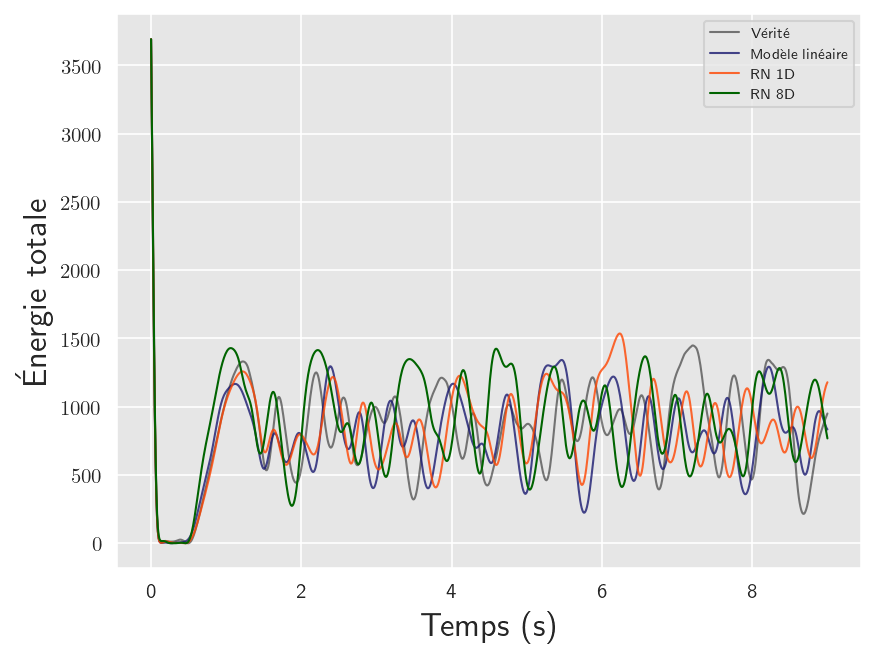

In [74]:
# Énergie totale
e_totale_mcg = np.sum(X_court, axis=1)**2 # (901,)
e_totale_linear = np.sum(Xevolution_linear, axis=1)**2     
e_totale_local = np.sum(Xevolution_local, axis=1)**2
e_totale_nonlocal = np.sum(Xevolution_nonlocal, axis=1)**2

# Graphique
plt.figure(dpi=150)
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

plt.plot(e_totale_mcg, label="Vérité", color='k', alpha=0.5, linewidth=1)

plt.plot(e_totale_linear, label="Modèle linéaire", color='midnightblue', alpha=0.8, linewidth=1)
plt.plot(e_totale_local, label="RN 1D", color='orangered', alpha=0.8, linewidth=1)
plt.plot(e_totale_nonlocal, label="RN 8D", color='darkgreen', linewidth=1)

plt.gca().set_xticklabels(np.arange(-2, 10, 2))

plt.legend(fontsize=7);
plt.ylabel(r"Énergie totale",fontsize=16)
plt.xlabel("Temps (s)",fontsize=16)

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/Eval_energie_1.png',dpi=500)

/var/folders/sw/5g8d908x7j9gb1wl9kmd_xq80000gn/T/ipykernel_26190/3726018961.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(np.arange(-2, 10, 2))


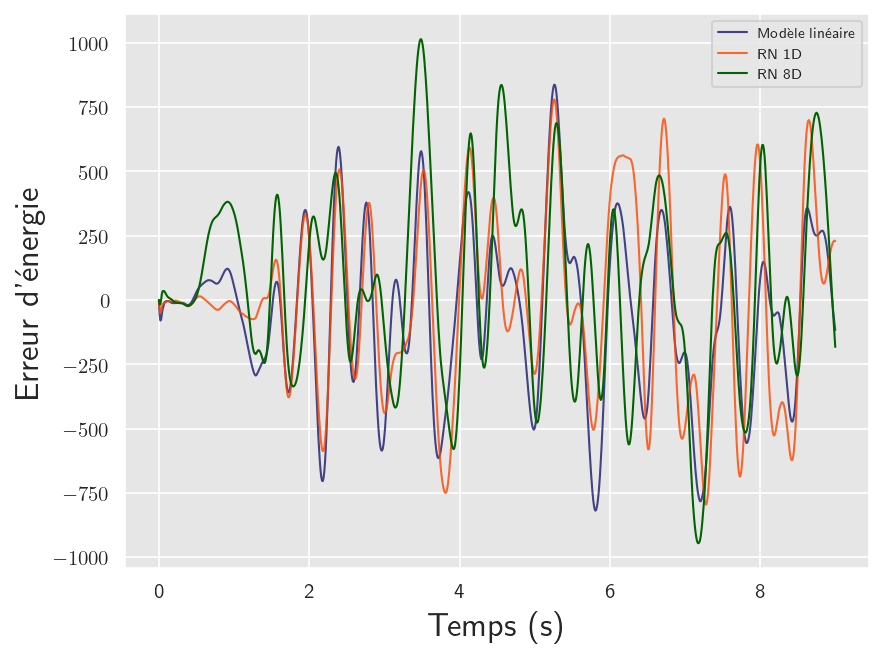

In [73]:
# Énergie totale
e_totale_mcg = np.sum(X_court, axis=1)**2 # (901,)
e_totale_linear = np.sum(Xevolution_linear, axis=1)**2     
e_totale_local = np.sum(Xevolution_local, axis=1)**2
e_totale_nonlocal = np.sum(Xevolution_nonlocal, axis=1)**2

# Graphique
plt.figure(dpi=150)
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

#plt.plot(e_totale_mcg, label="Vérité", color='k', alpha=0.5)

plt.plot(e_totale_linear-e_totale_mcg, label="Modèle linéaire", color='midnightblue', alpha=0.8, linewidth=1)
plt.plot(e_totale_local-e_totale_mcg, label="RN 1D", color='orangered', alpha=0.8, linewidth=1)
plt.plot(e_totale_nonlocal-e_totale_mcg, label="RN 8D", color='darkgreen', linewidth=1)

plt.gca().set_xticklabels(np.arange(-2, 10, 2))

plt.legend(fontsize=7);
plt.ylabel(r"Erreur d'énergie",fontsize=16)
plt.xlabel("Temps (s)",fontsize=16)

plt.savefig('/Users/evecastonguay/Desktop/Labo/E_04/Figures/Eval_energie_1.png',dpi=500)